# Retrieve Images in new Grids and Sampling

### Fei Zhang @Geoscience Australia

August 2016

## Introduction

Datacube APIs to retrieve gridded data (images), and output in new CRS and samplings - as long as the CRS is supported by python GDAL lib. 

### Related Topics: 

1) Userguide how to index a dataset (like DSM) make it recognised by datacube ?

2) How to export proper geotiff (and netcdf) files from the new images?

## Interactive Computing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pandas

import sys
sys.path.insert(0, '/g/data/u46/fxz547/Githubz/agdc-v2')#'/home/547/fxz547/myGithub/agdc-v2')  #prepend a path

In [2]:
# import AGDC Python API modules

import datacube
from datacube.storage import masking

# Create an API data access object
dc = datacube.Datacube(app='GetData')

dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://fxz547@130.56.244.227:6432/datacube)>>>

We can access the Postgres Database (metadata index) and its associated imagery data.

## Datacube Products List 
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [3]:
df_prodlist = dc.list_products()

df_prodlist.shape

(32, 15)

In [4]:
df_prodlist.head()

,name,description,product_type,sat_path,format,lon,platform,sat_row,instrument,time,lat,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
36,bom_rainfall_grids,Interpolated Rain Gauge Precipitation 1-Day Au...,rainfall,NaN,NETCDF,NaN,BoM,NaN,rain gauge,None,NaN,EPSG:4326,"[-0.05, 0.05]",None,"(latitude, longitude)"
32,dsm1sv10,DSM 1sec Version 1.0,DEM,NaN,ENVI,NaN,SRTM,NaN,SIR,None,NaN,EPSG:4326,"[-0.00027777777778, 0.00027777777778]",None,"(latitude, longitude)"
27,ls5_fc_albers,"Landsat 5 Fractional Cover 25 metre, 100km til...",fractional_cover,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"
2,ls5_level1_scene,Landsat 5 Level 1 At-sensor Radiance 25 metre,level1,NaN,GeoTiff,NaN,LANDSAT_5,NaN,TM,None,NaN,NaN,NaN,NaN,NaN
6,ls5_nbar_albers,"Landsat 5 Surface Reflectance NBAR 25 metre, 1...",nbar,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"


## Measurements List of the Products

- Each of the datacube products may have multiple measurements.

- Measurements are related to the sensors characteristics,  also known as _bands_ in the remote-sensing domain.

- _bands_ comes from electromagnetic wave spectral ranges, generally include Red-Green-Blue (RGB). 

In [5]:
df_measlist = dc.list_measurements()

df_measlist.shape

(99, 7)

In [6]:
df_measlist.head(2)

,,aliases,dtype,flags_definition,name,nodata,spectral_definition,units
product,measurement,,,,,,,
bom_rainfall_grids,rainfall,NaN,float32,NaN,rainfall,-999,NaN,mm
dsm1sv10,elevation,NaN,float32,NaN,elevation,NaN,NaN,metre


## Retrieving data


In [7]:
#To see the function signature?
#dc.load?

# Where?
xp=(149.07, 149.17); yp=(-35.25, -35.35)  # Lake Burley Griffin x=(149.07, 149.17), y=(-35.25, -35.35), 
# xp=( 149.160,  149.170); yp=(-35.34 , -35.35 )  #a small area cover GA water pond
xp=(149.28, 149.53); yp=(-34.98,  -35.25)  # Lake George small area
                
# When? a time range
tp=('2010-01', '2016-12-31')

prod_type='ls7_nbar_albers'
pq_prod_type = prod_type.replace('nbar','pq')

# output grid and associated resolution
v_output_crs=None; v_resolution=None   #None for default
# v_output_crs='EPSG:3112'; v_resolution=(-25,25)  #LCC 3112, Albers 3577
# output_crs='EPSG:4326', resolution=(-0.00025, 0.00025))

In [8]:

# nbar = dc.load(product=prod_type, x=xp, y=yp, time=tp, output_crs=v_output_crs, resolution=v_resolution)


The returned data is an `xarray.Dataset` object, which is a labelled n-dimensional array wrapping a `numpy` array.

We can investigate the data to see the variables (measurement bands) and dimensions that were returned:

In [9]:
nbar

NameError: name 'nbar' is not defined

We can look at the data by name directly, or through the `data_vars` dictionary:

In [ ]:
nbar.data_vars

In [ ]:
nbar.green

In [ ]:
print(nbar.red.shape)
print(nbar.green.shape)
print(nbar.blue.shape)
print(nbar.swir1.shape)  # short wave Length Infrared sensor

In [ ]:
print(nbar.time.min())

print(nbar.time.max())


## Create and Display a multi-band image

###  select a time-slice of the imagery stack
###  use pandas-style slicing to select a time period

In [10]:
itime=1

def show_images(nbar, itime):
    
    print ("Showing images acquired in datetime ", nbar.time.values[itime])
    
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)


    plt.figure( figsize=(16,14) )
    
    plt.subplot( 1,3,1 )
    plt.imshow(red_img)#, cmap='gray')
    plt.title("Red band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='red sensor measurement');

    
    plt.subplot( 1,3,2 )
    plt.imshow(green_img)   # plotting the subset data directly
    #plt.imshow(green_img, cmap='gray')
    plt.title("Green band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='green sensor measurement');


    plt.subplot( 1,3,3 )
    plt.imshow(blue_img)   # plotting the subset data directly
    #plt.imshow(blue_img, cmap='gray')
    plt.title("Blue band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='blue sensor measurement');

    return


In [11]:
# show the images of bands at itime=0,1, 10

show_images(nbar, 1)

NameError: name 'nbar' is not defined

Each band is a grayscale image. They can be combined to make a better image.

In [12]:
# define a scale function to strech an image 

def scale_array(arr, prcnt, min_val, max_val, nan_val):
    """
    Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val' and 'max_val', 
    replacing 'nan_val' values with NaN's.
    #f_arr = 1.0*arr #.astype('float')    # required for NaN's 
    """
  
    f_arr = arr.astype('float')
    #f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    
    return f_arr


In [44]:
def make_rgb_images(nbar, itime, outfname=None):
    """
    Create a RGB image using bands acquired at itime
    """
    print ("RGB image acquired in datetime ", nbar.time.values[itime])
        
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)


    plt.figure( figsize=(10,10) )
    
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)
    y_size = red_img.shape[0]; x_size = red_img.shape[1]

    print (y_size,x_size)
    #print red_img.shape

    sB1data = scale_array(red_img, 99.0, 0, 255, -999)
    sB2data = scale_array(green_img, 99.0, 0, 255, -999)
    sB3data = scale_array(blue_img, 99.0, 0, 255, -999)


    rgb_image = np.zeros((y_size, x_size, 3), dtype='uint8')
    rgb_image[:,:,0] = sB1data; 
    rgb_image[:,:,1] = sB2data; 
    rgb_image[:,:,2] = sB3data
    
    if outfname is None:
        title_str= 'Landsat Image over the Area: %s, %s'% (str(xp), str(yp))
        plt.title(title_str)
        plt.ylabel('northing'); plt.xlabel('easting');
        plt.imshow(rgb_image, interpolation='none')
    else:
        plt.imsave(outfname, rgb_image)
    
#     output_figure_name = 'nbar_nature_color.jpg'
#     plt.savefig(output_figure_name, dpi=400)

In [14]:
# good images: 3,4, 6
# cloudy images: itime=0,1
# no-data blank tiles: 2,5

make_rgb_images(nbar, 2)

NameError: name 'nbar' is not defined

# Export to geotiff raster file

In [35]:
import rasterio

DEFAULT_PROFILE = {
    'blockxsize': 256,
    'blockysize': 256,
    'compress': 'lzw',
    'driver': 'GTiff',
    'interleave': 'band',
    'nodata': 0.0,
    'photometric': 'RGBA',
    'tiled': True}


def write_geotiff(filename, dataset, time_index=None, profile_override=None):
    """
    Write an xarray dataset to a geotiff

    :attr bands: ordered list of dataset names
    :attr time_index: time index to write to file
    :attr dataset: xarray dataset containing multiple bands to write to file
    :attr profile_override: option dict, overrides rasterio file creation options.
    """
    profile_override = profile_override or {}

    dtypes = {val.dtype for val in dataset.data_vars.values()}
    assert len(dtypes) == 1  # Check for multiple dtypes

    profile = DEFAULT_PROFILE.copy()
    profile.update({
        'width': dataset.dims[dataset.crs.dimensions[1]],
        'height': dataset.dims[dataset.crs.dimensions[0]],
        'affine': dataset.affine,
        'crs': dataset.crs.crs_str,
        'count': len(dataset.data_vars),
        'dtype': str(dtypes.pop()),
        'nodata': dataset.red.nodata
    })
    profile.update(profile_override)

    with rasterio.open(filename, 'w', **profile) as dest:
        for bandnum, data in enumerate(dataset.data_vars.values(), start=1):
            dest.write(data.isel(time=time_index).data, bandnum)

In [39]:
import os

def export_datasets(ds, fn_prefix):
    for itime in xrange (0,len(ds.time)):
        fntime=str(ds.time.values[itime])[:19].replace(':','')
        fname ="%s_%s.tiff"%(fn_prefix,fntime)
        fname2="%s_%s.png"%(fn_prefix,fntime)
        
        path2fname=os.path.join("/short/v10/fxz547/Dexport",fname)
        path2fname2 =os.path.join("/short/v10/fxz547/Dexport",fname2)

        write_geotiff(path2fname,ds, itime)
        
        make_rgb_images(ds, itime, path2fname2 )
        
        

In [ ]:
len(nbar.time)

# export_datasets(nbar, 'nbar')

## Group  by solar day function

- There is a bit of overlap between two adjacent scenes ("cut").
- To remove the overlap duplication, we combine the data slices with datetimes less than a minute apart.  


In [ ]:
# nbar_by_solar_day = dc.load(product=prod_type, x=xp, y=yp, time=tp, group_by='solar_day')

# how many time-indexed images
# len(nbar_by_solar_day.time)

Now we have fewer timeslices than found previously without solar-day-grouping

According to Landsat cycle 16 days, 365/16 = 22 re-visit a place at least per year 

(For some region like Canberra, there will be overlap between passes)
Can be checked in the Clear Observation Layer at: http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm

In [ ]:
# show the images of bands at itime=0,1,2,3,4,... 10

show_images(nbar_by_solar_day, 4)

In [ ]:
nbar_by_solar_day

## Clean images and cloudy images in AGDC


In [ ]:
# 0, 5, 8 not cloudy
# 1,2,3,4 cloudy day
make_rgb_images(nbar_by_solar_day, 5 )

##  Applications

### Derive information products 

### Must identify and remove invalid observations: cloud, shadow, satuared pixels

### Band maths: combine the bands to derive new variables (artificial bands)

-  Normalized Difference Vegetation Index, NDVI
-  Normalized Difference Water Index,  NDWI
-  These index can help to clearly identify certain land cover features: Vegetation, water bodies

In [17]:
# Select best RGB NDVI NDWI images: eg,70% good valid pixels

Good_Pixels_Pct=70

In [18]:
#  retrieve a subset of bands

bands = dc.load(product=prod_type, x=xp, y=yp, time=tp, measurements=['red', 'nir', 'green', 'swir1','blue'], 
                group_by='solar_day')
red = bands.red.where(bands.red != bands.red.attrs['nodata'])
nir = bands.nir.where(bands.nir != bands.nir.attrs['nodata'])
                    
green = bands.green.where(bands.green != bands.green.attrs['nodata'])
swir1 = bands.swir1.where(bands.swir1 != bands.swir1.attrs['nodata'])

# Retrieve the associated Pixel Quality datasets. pq has issue with group_by_solar_day 
# They may not match all the Nbar products
pq = dc.load(product=pq_prod_type, x=xp, y=yp,  time=tp, group_by='solar_day') #, fuse_func='')

cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality


In [19]:
# inspect the xarray.Datasets 
print (bands.dims)
print (pq.dims)

print(bands.geobox); 
print(pq.geobox)


print (bands.indexes)
print (pq.indexes)

print (bands.crs)
print(bands.data_vars)
print (bands.coords)


Frozen(SortedKeysDict({'y': 1314, 'x': 1065, 'time': 126}))
Frozen(SortedKeysDict({'y': 1314, 'x': 1065, 'time': 112}))
GeoBox([(149.23574398864878, -34.98481185265389), (149.28440934686134, -35.277494015187685), (149.57489242234996, -35.24492327146266), (149.52542966880821, -34.95235578200322)])
GeoBox([(149.23574398864878, -34.98481185265389), (149.28440934686134, -35.277494015187685), (149.57489242234996, -35.24492327146266), (149.52542966880821, -34.95235578200322)])
time: DatetimeIndex(['2010-01-13', '2010-01-29', '2010-03-02', '2010-04-03',
                     '2010-04-19', '2010-05-21', '2010-06-29', '2010-07-08',
                     '2010-07-24', '2010-08-09',
                     ...
                     '2015-09-08', '2015-09-24', '2015-10-10', '2015-10-26',
                     '2015-11-27', '2015-12-13', '2015-12-29', '2016-06-06',
                     '2016-06-13', '2016-06-22'],
                    dtype='datetime64[ns]', name=u'time', length=126, freq=None)
x: Float64I

In [20]:
bands.red.nodata

-999

### Compute Indexes: NDVI and NDWI

#### Numpy array arithmetics without looping

In [21]:

# Normalized Differenc Vegetation Index: Red and near Infrared bands

ndvi = ((nir - red) / (nir + red)).where(cloud_free)

# Normalized Differenc Water Index: Green and Shortwave Infrared Bands

ndwi = ((swir1- green)/(green + swir1)).where(cloud_free)

#ndwi = ((green- swir1)/(green + swir1)).where(cloud_free)

ndvi.shape


(112, 1314, 1065)

In [22]:
ndwi.shape

(112, 1314, 1065)

In [23]:
# skip ndvi plots 
#ndvi.plot(col='time', col_wrap=6)

###  Weed out the low quality images.

In [24]:
# xarray.Dataset.sum to reduce the datasets by selecting the time slices with high percentage cloud-free pixels

cloudfreeRatio = 0.01*Good_Pixels_Pct # threshold of cloud pixel 80%

mostly_cloud_free = cloud_free.sum(dim=('x','y')) > (cloudfreeRatio * cloud_free.size / cloud_free.time.size)

print(mostly_cloud_free)

# How many images selected?

print(mostly_cloud_free.sum().values)

<xarray.DataArray 'pixelquality' (time: 112)>
array([False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False,  True, False, False,  True,
       False, False,  True,  True, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False,  True,  True, False,
        True, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False,  True,  True, False, False,  True,  True,  True,  True,
       False,  True,  True, False, False, False,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-13 2010-01

In [25]:

seltimes=[]
for itime in xrange(0,len(mostly_cloud_free)):  
    if mostly_cloud_free[itime].values:
        print (itime, mostly_cloud_free[itime].values, mostly_cloud_free[itime].time.values )
        seltimes.append(mostly_cloud_free[itime].time.values)
        
print seltimes  

(9, array(True, dtype=bool), numpy.datetime64('2010-09-10T10:00:00.000000000+1000'))
(10, array(True, dtype=bool), numpy.datetime64('2010-10-12T11:00:00.000000000+1100'))
(14, array(True, dtype=bool), numpy.datetime64('2011-02-01T11:00:00.000000000+1100'))
(17, array(True, dtype=bool), numpy.datetime64('2011-05-08T10:00:00.000000000+1000'))
(20, array(True, dtype=bool), numpy.datetime64('2011-07-11T10:00:00.000000000+1000'))
(21, array(True, dtype=bool), numpy.datetime64('2011-07-27T10:00:00.000000000+1000'))
(27, array(True, dtype=bool), numpy.datetime64('2011-10-31T11:00:00.000000000+1100'))
(32, array(True, dtype=bool), numpy.datetime64('2012-02-04T11:00:00.000000000+1100'))
(37, array(True, dtype=bool), numpy.datetime64('2012-05-10T10:00:00.000000000+1000'))
(42, array(True, dtype=bool), numpy.datetime64('2012-07-29T10:00:00.000000000+1000'))
(43, array(True, dtype=bool), numpy.datetime64('2012-08-14T10:00:00.000000000+1000'))
(45, array(True, dtype=bool), numpy.datetime64('2012-09

In [40]:
def filter_export_datasets(ds, fn_prefix, times):
    for itime in xrange(0,len(ds.time)):
        #print (ds.time.values[itime])
        if ds.time.values[itime] in times:
            print (itime)
            
            fntime=str(ds.time.values[itime])[:19].replace(':','')
            fname ="%s_%s.tiff"%(fn_prefix,fntime)
            fname2="%s_%s.png"%(fn_prefix,fntime)
            
            path2fname=os.path.join("/short/v10/fxz547/Dexport",fname)
            path2fname2 =os.path.join("/short/v10/fxz547/Dexport",fname2)

            write_geotiff(path2fname,ds, itime)

            make_rgb_images(ds, itime, path2fname2 )
        

In [42]:
# filter_export_datasets(bands,"CleanImages_LakeGorge",seltimes)

('RGB image acquired in datetime ', numpy.datetime64('2015-12-29T11:00:00.000000000+1100'))
(1314, 1065)


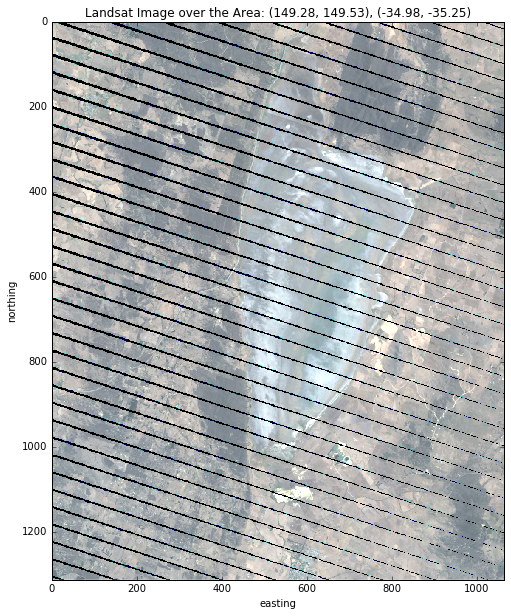

In [45]:
# Display the nearly cloud free images [0, 8, 9, 11, 12, 20, 24, 26, 30, 32, 34]
it=122
make_rgb_images(bands, it)


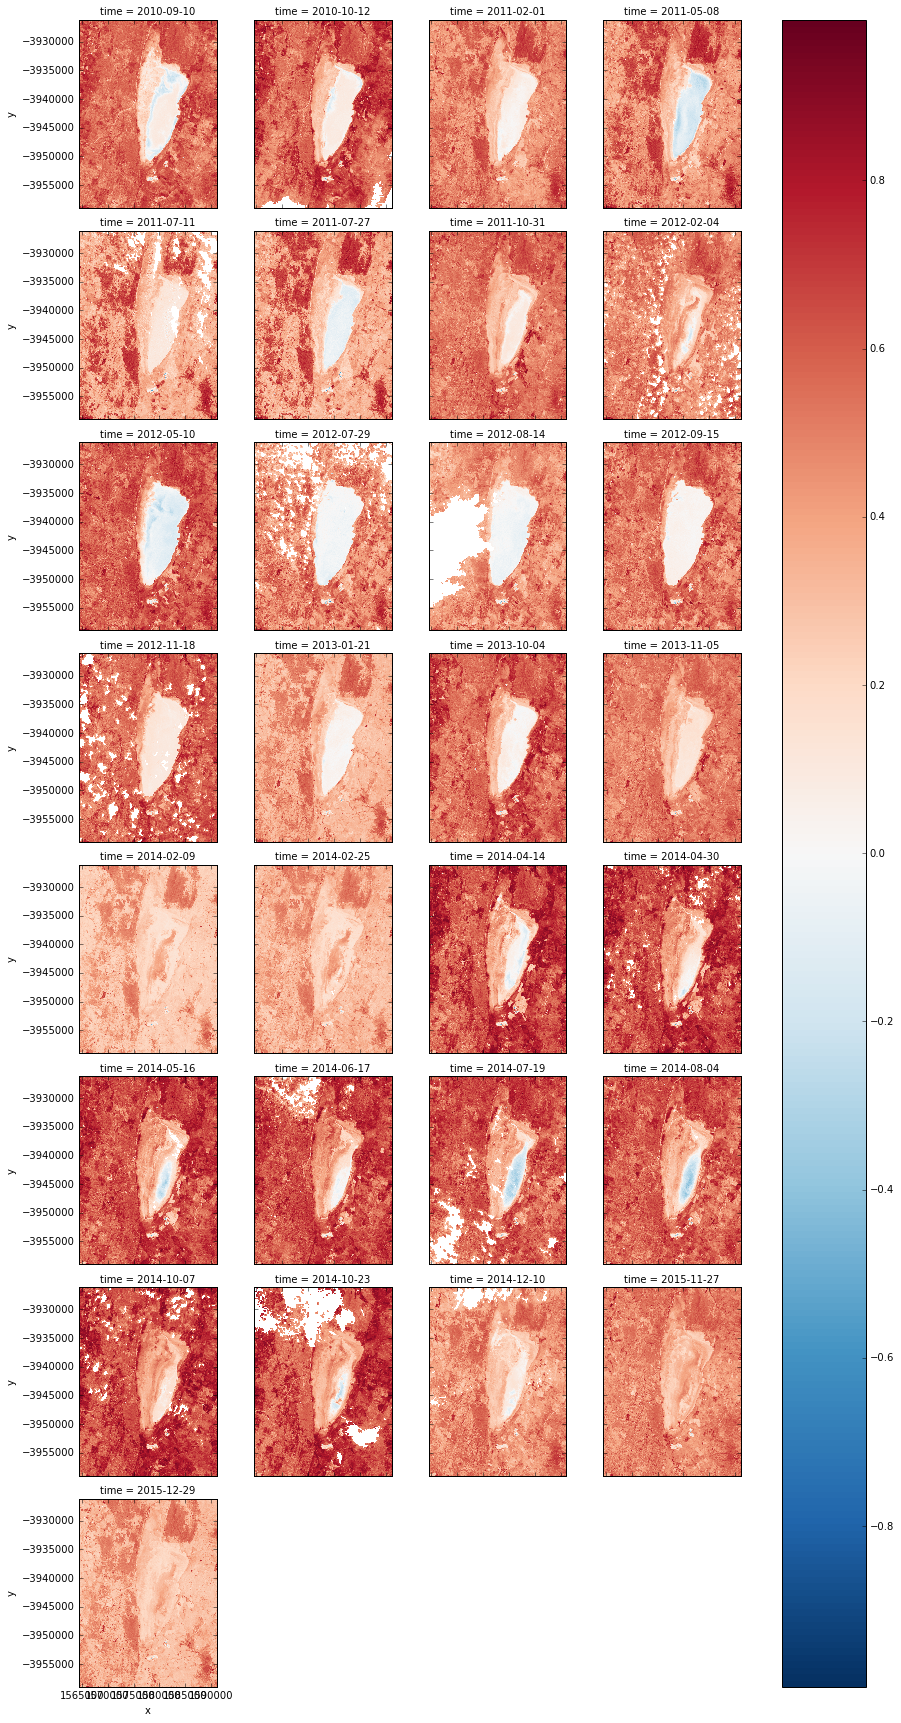

In [29]:
# Apply the time-dim mask to the 3D-array (time, x, y)
mostly_good_ndvi = ndvi.where(mostly_cloud_free).dropna('time', how='all')
mostly_good_ndvi.plot(col='time', col_wrap=4)

In [30]:
mostly_good_ndvi

<xarray.DataArray (time: 29, y: 1314, x: 1065)>
array([[[        nan,         nan,         nan, ...,  0.63822149,
          0.63822149,  0.66545675],
        [        nan,         nan,         nan, ...,  0.64255319,
          0.63636364,  0.638865  ],
        [        nan,         nan,         nan, ...,  0.62720546,
          0.62720546,  0.64961068],
        ..., 
        [        nan,         nan,         nan, ...,  0.47603834,
          0.51539763,  0.52676801],
        [        nan,         nan,         nan, ...,  0.51697585,
          0.59376189,  0.5797777 ],
        [        nan,         nan,         nan, ...,  0.51390476,
          0.54747475,  0.60420725]],

       [[ 0.72939787,  0.70554985,  0.7295393 , ...,  0.71409275,
          0.70554139,  0.72520171],
        [ 0.73282098,  0.70305677,  0.67535923, ...,  0.69234393,
          0.73301549,  0.74603175],
        [ 0.66454545,  0.68449438,  0.67607304, ...,  0.68159204,
          0.72581385,  0.72723368],
        ..., 
    

In [31]:

How to export xarray.DataArray (time: 11, y: 490, x: 420) into geotiff?

red, green, blue, swir1

NDVI

NDWI



Object `geotiff` not found.


NameError: name 'blue' is not defined

In [ ]:
How to export xarray.DataArray (time: 11, y: 490, x: 420) into geotiff

In [ ]:
How to export xarray.DataArray (time: 11, y: 490, x: 420) into geotiff

## Normalised Difference Water Index

In [ ]:
# images after removed invalid pixels. 
#ndwi.plot(col='time', col_wrap=6)


### Weed out the low quality images.

In [ ]:
# apply the cloud_threshold mask, which will select a subset images with good pixels. 

mostly_good_ndwi = ndwi.where(mostly_cloud_free).dropna('time', how='all')

mostly_good_ndwi.plot(col='time', col_wrap=5)

In [ ]:
stop

## Statistics Median and Mean Images

### Normalised Vegetation Index vs Water Index

In [ ]:
plt.figure( figsize=(16,12) )
    
plt.subplot( 2,2,1 )
mostly_good_ndvi.median(dim='time').plot()
plt.title("Median Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,2 )
mostly_good_ndvi.mean(dim='time').plot()
# ndvi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')

#------------------------------
plt.subplot( 2,2,3 )
mostly_good_ndwi.median(dim='time').plot()
plt.title("Median Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,4 )
mostly_good_ndwi.mean(dim='time').plot()
# ndwi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')

# Water Observation from Space

http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm


## DSM dataset indexed in DC

In [ ]:
grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35))
grid.elevation

In [ ]:
grid.elevation[0].plot()

## Re-projection and Re-sampling 

In [ ]:
# http://spatialreference.org/ref/epsg/gda94-geoscience-australia-lambert/ 3112
# EPSG:3577: GDA94 / Australian Albers
# EPSG:3112 GDA94 / Geoscience Australia Lambert

In [ ]:
albers_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35), 
                      output_crs='EPSG:3577', resolution=(-25,25))

albers_grid.elevation.shape

In [ ]:
albers_grid.elevation[0].plot()

In [ ]:
lcc_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35), 
                      output_crs='EPSG:3112', resolution=(-25,25))

lcc_grid.elevation.shape
lcc_grid.elevation[0].plot()

In [ ]:
geosphere_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.35,-35.25),output_crs='EPSG:4326', resolution=(-0.00025, 0.00025))

geosphere_grid.elevation.shape


In [ ]:
query = {
    'lat': (-35.2, -35.4),
    'lon': (149.0, 149.2),
}

dsmgrid=dc.load(product='dsm1sv10', output_crs='EPSG:4326', resolution=(-0.00025, 0.00025), **query)

dsmgrid.elevation.shape

In [ ]:
dsmgrid.elevation[0].plot()

In [ ]:
#landsat = dc.load(product='ls5_nbar_albers', x=(149.25, 149.35),y=(-35.25, -35.35), time=('2011-01-01', '2011-03-01'), output_crs='EPSG:4326', resolution=(-0.00025, 0.00025))
landsat = dc.load(product='ls5_nbar_albers', x=(149.25, 149.35),y=(-35.25, -35.35), time=('2011-01-01', '2011-03-01'), output_crs='EPSG:4326', resolution=(-0.001, 0.001))

landsat.green[0].plot()

In [ ]:
landsat

In [ ]:
!getfacl /g/data/v10/projects/ingest_test_data/milestone1/dsm1sv1_0_Clean/